In [80]:
from dl_toolbox.torch_datasets import *
import dl_toolbox.inference as dl_inf 

#IMAGE_PATH = '/d/pfournie/ai4geo/data/DIGITANIE/Toulouse/toulouse_tuile_6_img_normalized.tif'
#IMAGE_PATH = '/work/OT/ai4usr/fournip/miniworld_tif/christchurch/test/10_x.tif'
IMAGE_PATH = '/work/OT/ai4usr/fournip/digitanie/Toulouse/toulouse_tuile_1_img_normalized.tif'

#IMAGE_PATH = '/work/OT/ai4usr/fournip/SemCity-Toulouse-bench/img_multispec_05/TLS_BDSD_M/TLS_BDSD_M_01.tif'
#FULL_RASTER_PATH = '/d/pfournie/ai4geo/data/DIGITANIE/Toulouse/normalized_mergedTO.tif'
FULL_RASTER_PATH = '/work/OT/ai4usr/fournip/digitanie/Toulouse/toulouse_full_tiled.tif'

TILE = (0, 0, 2000, 2000)
CROP_SIZE = 2000
CROP_STEP = 256
LABELS='building'
MERGE='building'
CLASS = DigitanieToulouseDs
#CLASS = SemcityBdsdDs

window = dl_inf.get_window(TILE)
dataset = CLASS(
    labels=LABELS,
    label_merger=MERGE,
    image_path=IMAGE_PATH,
    full_raster_path=FULL_RASTER_PATH,
    fixed_crops=True,
    tile=window,
    crop_size=CROP_SIZE,
    crop_step=CROP_STEP,
    img_aug='no'
)

In [81]:
ds_out = next(iter(dataset))

In [82]:
image = ds_out['orig_image'].numpy().transpose(1,2,0)
image *= 255.
image = image.astype(np.uint8)

In [83]:
img_stack = []
im = image.reshape(-1, 3)
img_stack.append(im)
all_pixels = np.vstack(img_stack)
centered = all_pixels - np.mean(all_pixels, axis=0)
cov = np.cov(centered, rowvar=False)
eig_vals, eig_vecs = np.linalg.eigh(cov)
print(eig_vals)
print(eig_vecs)

[  1.36717939   3.66982325 455.13470076]
[[ 0.04273315 -0.83459118 -0.54920984]
 [-0.67618728  0.38051685 -0.63085473]
 [ 0.73548939  0.39832711 -0.54807925]]


In [84]:
def apply(img, vals, vecs, alpha=(0.1, 0.1, 0.1), **params):

    if img.dtype != np.uint8:
        raise TypeError("Image must be RGB image in uint8 format.")

    orig_img = img.astype(float).copy()

    sort_perm = vals[::-1].argsort()
    vals[::-1].sort()
    eig_vecs = vecs[:, sort_perm]
    m1 = np.column_stack((eig_vecs))
    # get 3x1 matrix of eigen values multiplied by random variable draw from normal
    # distribution with mean of 0 and standard deviation of 0.1
    m2 = np.zeros((3, 1))
    # broad cast to speed things up
    m2[:, 0] = alpha * vals[:]
    #m2[:, 0] = np.array((4., 4., 4.)) * vals[:]
    # this is the vector that we're going to add to each pixel in a moment
    add_vect = np.matrix(m1) * np.matrix(m2)
    for idx in range(3):  # RGB
        orig_img[..., idx] += add_vect[idx] * 255
    # for image processing it was found that working with float 0.0 to 1.0
    # was easier than integers between 0-255
    # orig_img /= 255.0
    orig_img = np.clip(orig_img, 0.0, 255.0)
    # orig_img *= 255
    orig_img = orig_img.astype(np.uint8)

    return orig_img

In [85]:
aug = apply(img=image, 
            vals=ISPRS_EIGENVALS, 
            vecs=ISPRS_EIGENVECS,
            alpha=(1,1,1))

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import exposure

def visualize(image, aug):
    
    aug_plot = exposure.adjust_gamma(aug, 0.5)
    img_plot = exposure.adjust_gamma(image, 0.5)
    
    fontsize = 18
    f, ax = plt.subplots(1, 2, figsize=(8, 16))

    ax[0].imshow(img_plot.astype(np.uint8))
    ax[0].set_title('Orig image', fontsize=fontsize)

    ax[1].imshow(aug_plot.astype(np.uint8))
    ax[1].set_title('Correct FancyPCA', fontsize=fontsize)

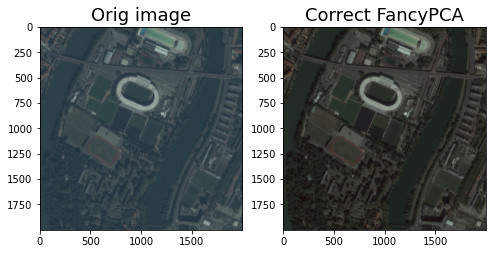

In [88]:
visualize(image=image, aug=aug)

In [79]:
image - aug

array([[[1, 1, 2],
        [1, 1, 2],
        [1, 1, 2],
        ...,
        [1, 1, 2],
        [1, 1, 2],
        [1, 1, 2]],

       [[1, 1, 2],
        [1, 1, 2],
        [1, 1, 2],
        ...,
        [1, 1, 2],
        [1, 1, 2],
        [1, 1, 2]],

       [[1, 1, 2],
        [1, 1, 2],
        [1, 1, 2],
        ...,
        [1, 1, 2],
        [1, 1, 2],
        [1, 1, 2]],

       ...,

       [[1, 1, 2],
        [1, 1, 2],
        [1, 1, 2],
        ...,
        [1, 1, 2],
        [1, 1, 2],
        [1, 1, 2]],

       [[1, 1, 2],
        [1, 1, 2],
        [1, 1, 2],
        ...,
        [1, 1, 2],
        [1, 1, 2],
        [1, 1, 2]],

       [[1, 1, 2],
        [1, 1, 2],
        [1, 1, 2],
        ...,
        [1, 1, 2],
        [1, 1, 2],
        [1, 1, 2]]], dtype=uint8)